In [23]:
# plot packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=20)

# others
import numpy as np
import os, time
import torch
from scipy.stats import multivariate_normal

In [225]:
def centroids_to_edges(centroids):
    """
    Convert an array of bin centroids to bin edges.
    Parameters:
        centroids (array-like): 1D array of bin centroids (must be sorted).
    Returns:
        np.ndarray: 1D array of bin edges, length = len(centroids) + 1
    """
    centroids = np.asarray(centroids)
    if centroids.ndim != 1:
        raise ValueError("Input must be a 1D array of centroids.")
    if len(centroids) < 2:
        raise ValueError("At least two centroids are required to compute edges.")
    
    midpoints = (centroids[:-1] + centroids[1:]) / 2
    first_edge = centroids[0] - (midpoints[0] - centroids[0])
    last_edge = centroids[-1] + (centroids[-1] - midpoints[-1])
    edges = np.concatenate([[first_edge], midpoints, [last_edge]])
    return edges

def ratio_with_error(a, b, a_err, b_err):
    """
    Compute the element-wise ratio of two arrays with error propagation.
    
    Parameters:
        a (np.ndarray): Numerator values
        b (np.ndarray): Denominator values
        a_err (np.ndarray): Errors in numerator
        b_err (np.ndarray): Errors in denominator
        
    Returns:
        ratio (np.ndarray): Element-wise ratio a / b
        ratio_err (np.ndarray): Propagated uncertainty of the ratio
    """
    a = np.asarray(a)
    b = np.asarray(b)
    a_err = np.asarray(a_err)
    b_err = np.asarray(b_err)
    if not (a.shape == b.shape == a_err.shape == b_err.shape):
        raise ValueError("All input arrays must have the same shape.")
    ratio = a / b
    ratio_err = ratio * np.sqrt((a_err / a)**2 + (b_err / b)**2)
    return ratio, ratio_err

def plot_reconstruction(data, # 
                        weight_data, ref, weight_ref, ref_preds, 
                        xlabels=[], #[D]
                        bins_centroids = [], #[Nb, D]
                        f_bins_centroids = [], #[Nb, D]
                        ferr_bins_centroids = [], #[Nb, D]
                        yrange=None,
                        save=False, save_path='', file_name=''):
    '''
    Reconstruction of the data distribution learnt by the model.
    df:              (int) chi2 degrees of freedom                                                                         
    data:            (numpy array, shape (None, n_dimensions)) data training sample (label=1)                                      
    ref:             (numpy array, shape (None, n_dimensions)) reference training sample (label=0)
    weight_ref:      (numpy array, shape (None,)) weights of the reference sample                                                  
    tau_OBS:         (float) value of the tau term after training
    output_tau_ref:  (numpy array, shape (None, 1)) tau prediction of the reference training sample after training
    feature_labels:  (list of string) list of names of the training variables 
    bins_code:       (dict) dictionary of bins edge for each training variable (bins_code.keys()=feature_labels)
    xlabel_code:     (dict) dictionary of xlabel for each training variable (xlabel.keys()=feature_labels)   
    ymax_code:       (dict) dictionary of maximum value for the y axis in the ratio panel 
                     for each training variable (ymax_code.keys()=feature_labels) 
    delta_OBS:       (float) value of the delta term after training (if not given, only tau reconstruction is plotted) 
    output_delta_ref:(numpy array, shape (None, 1)) delta prediction of the reference training sample after training 
                     (if not given, only tau reconstruction is plotted)     
    '''
    eps = 1e-10

    weight_ref = np.ones(len(ref))*weight_ref
    weight_data = np.ones(len(data))*weight_data

    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    for i in range(data.shape[1]):
        #All = np.append(ref[:, i], data[:, i])
        bins = centroids_to_edges(bins_centroids[:,i])#np.linspace(np.min(All),np.max(All),30)
        N = np.sum(weight_ref)
        bins_legth = (bins[1:]-bins[:-1])*N
        
        fig = plt.figure(figsize=(14, 8))
        fig.patch.set_facecolor('white')
        ax1= fig.add_axes([0.15, 0.43, 0.5, 0.5])
        hD = ax1.hist(data[:, i],weights=weight_data, bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=2)
        hR = ax1.hist(ref[:, i], weights=weight_ref, color='darkturquoise', ec='darkturquoise', alpha=0.3, bins=bins, lw=1, label='REFERENCE', zorder=1)
        hN = ax1.hist(ref[:, i], weights=np.exp(ref_preds[:, 0])*weight_ref, histtype='step', bins=bins, lw=0)
        #ax1.plot(bins_centroids[:, i], bins_legth*f_bins_centroids[:, i])
        plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0], yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
        plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN[0], edgecolor='black', label='NPLM RECO', color='#b2df8a', lw=1, s=30, zorder=4)

        font = font_manager.FontProperties(family='serif', size=16)
        l    = plt.legend(fontsize=18, prop=font, ncol=1, frameon=False, 
                          bbox_to_anchor=(1.05, 1),loc='upper left',borderaxespad=0.)
        font = font_manager.FontProperties(family='serif', size=18)
        plt.tick_params(axis='x', which='both',    labelbottom=False)
        plt.yticks(fontsize=16, fontname='serif')
        plt.xlim(bins[0], bins[-1])
        plt.ylabel("events", fontsize=22, fontname='serif')
        plt.yscale('log')
        ax2 = fig.add_axes([0.15, 0.1, 0.5, 0.3])
        x   = bins_centroids[:, i]
        area= np.sum(bins_legth*f_bins_centroids[:, i])
        print("Area: ", area)
        ratio, ratio_err = ratio_with_error(N/area*bins_legth*f_bins_centroids[:, i], hR[0], N/area*bins_legth*ferr_bins_centroids[:, i], np.sqrt(hR[0]))
        ratio_nplm = hN[0]/(hR[0]+eps)
        ratio_nplm_x = x[ratio_nplm>0]
        ratio_nplm = ratio_nplm[ratio_nplm>0]
        ax2.errorbar(x, hD[0]/(hR[0]+eps), yerr=np.sqrt(hD[0])/(hR[0]+eps), ls='', marker='o', label ='DATA/REF', color='black',zorder=1)
        ax2.plot(ratio_nplm_x, ratio_nplm, label ='NPLM RECO/REF', color='#b2df8a', lw=3, )
        
        # Plot the central ratio line
        ax2.plot(x, ratio, label=r'MODEL/REF', color='blue')
        # ±1σ band
        ax2.fill_between(x, ratio - ratio_err, ratio + ratio_err, color='blue', alpha=0.3, label=r'$\pm 1 \sigma$')
        # ±2σ band
        ax2.fill_between(x, ratio - 2*ratio_err, ratio + 2*ratio_err, color='blue', alpha=0.15, label=r'$\pm 2 \sigma$')
        
        font = font_manager.FontProperties(family='serif', size=16)
        plt.legend(fontsize=18, prop=font, bbox_to_anchor=(1.05, 1),
        loc='upper left', frameon=False, 
        borderaxespad=0.)

        if len(xlabels)>0:
            plt.xlabel(xlabels[i], fontsize=22, fontname='serif')
        else:
            plt.xlabel('x', fontsize=22, fontname='serif')
        plt.ylabel("ratio", fontsize=22, fontname='serif')

        plt.yticks(fontsize=16, fontname='serif')
        plt.xticks(fontsize=16, fontname='serif')
        plt.xlim(bins[0], bins[-1])
        plt.ylim(0, 2)

        if len(xlabels):
            if not yrange==None and len(xlabels)>0:
                plt.ylim(yrange[xlabels[i]][0], yrange[xlabels[i]][1])
        plt.grid()
        if save:
            os.makedirs(save_path, exist_ok=True)
            #fig.savefig(save_path+file_name.replace('.pdf', '_%i.pdf'%(i)))
            fig.savefig(save_path+file_name.replace('.pdf', '_%i.png'%(i)))
        plt.show()
        plt.close()
    return

In [226]:
bins_centroids = []
f = []
f_err = []
for i in range(2):
    i=i+1
    d = np.load('./marginal_feature_%i_data_30.npz'%(i))
    bins_centroids.append(d['bin_centers'])
    f.append(d['f_binned'])
    f_err.append(d['f_err'])
bins_centroids = np.stack(bins_centroids, axis=1)
f = np.stack(f, axis=1)
f_err = np.stack(f_err, axis=1)

Area:  20039.594055574584


/var/folders/t_/9vmmnz591vn599s7hm98kz480000gn/T/ipykernel_64306/1881309374.py:41: RuntimeWarning: divide by zero encountered in divide
  ratio = a / b
/var/folders/t_/9vmmnz591vn599s7hm98kz480000gn/T/ipykernel_64306/1881309374.py:42: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio * np.sqrt((a_err / a)**2 + (b_err / b)**2)


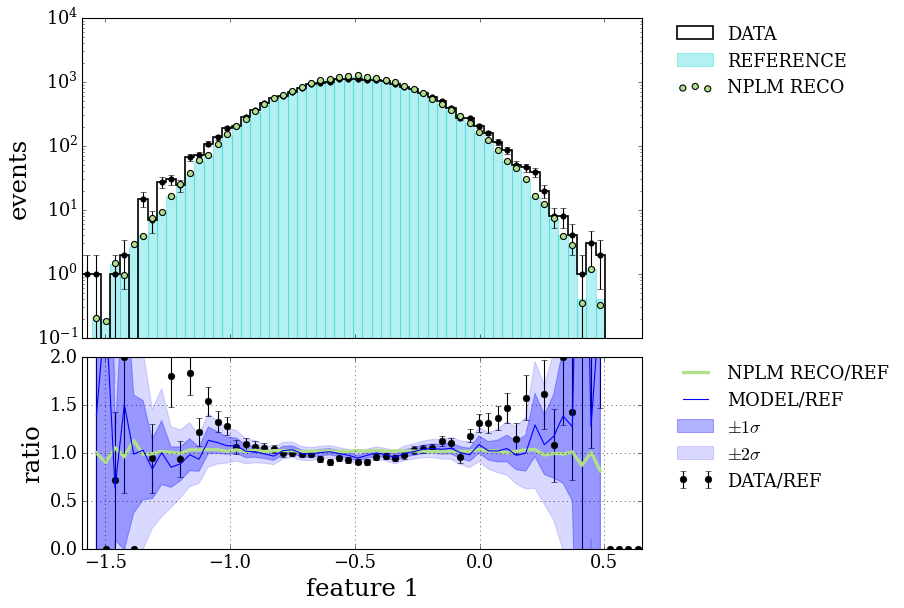

Area:  31417.618180484802


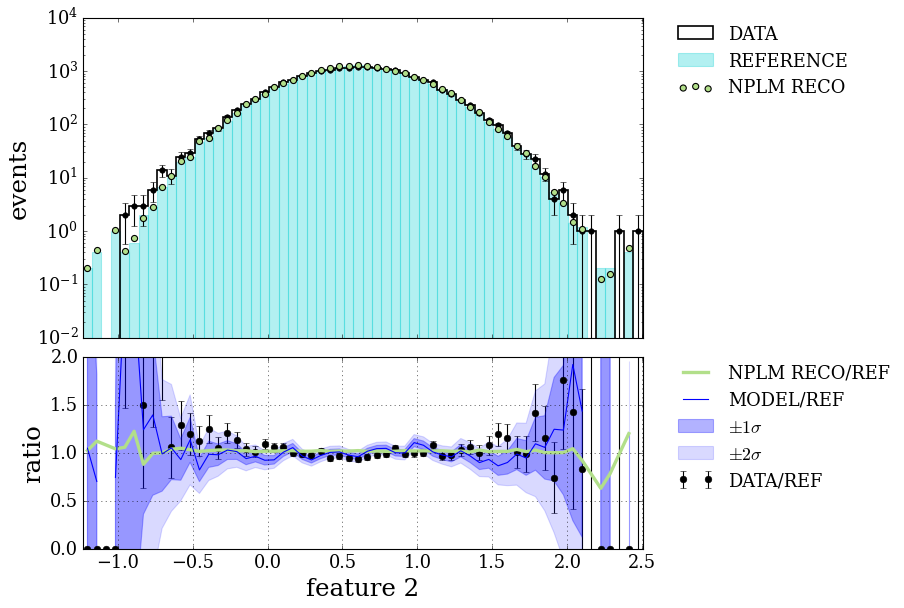

In [227]:
ref = np.random.multivariate_normal(mean=[-0.5, 0.6], cov= [[0.25**2, 0], [0, 0.4**2]], size=100000)
#data = np.load('./ensemble_generated_samples_4_16_128_15.npy')[:20000]#
data=np.random.multivariate_normal(mean=[-0.5, 0.6], cov= [[0.25**2, 0], [0, 0.4**2]], size=20000)
noise = np.random.multivariate_normal(mean=[0., 0.], cov= [[1, 0], [0, 1]], size=20000)*0.1
data = data+noise

weight_data = np.ones(data.shape[0])
weight_ref = np.ones(ref.shape[0])*20000/100000.
ref_preds = np.random.multivariate_normal(mean=[0., 0.], cov= [[1, 0], [0, 1]], size=100000)*0.2


#bins = np.linspace(-3, 4, 30)
#bins_centroids = 0.5*(bins[1:]+bins[:-1])
#bin_len = bins[1]-bins[0]
#f = 20000*bin_len*np.stack([multivariate_normal.pdf(bins_centroids, mean=-0.5, cov=0.25),multivariate_normal.pdf(bins_centroids, mean=0.6, cov=0.4)], axis=1)
#f = f+np.random.multivariate_normal(mean=[0., 0.], cov= [[1, 0], [0, 1]], size=len(bins_centroids))*0.1
#ferr = np.random.multivariate_normal(mean=[0., 0.], cov= [[1, 0], [0, 1]], size=len(bins_centroids))*0.1



plot_reconstruction(data, weight_data, ref, weight_ref, ref_preds, 
                    bins_centroids = bins_centroids,#np.stack([bins_centroids, bins_centroids], axis=1), #[Nb, D]
                    f_bins_centroids = f, #[Nb, D]
                    ferr_bins_centroids = f_err, #[Nb, D]
                    xlabels=['feature 1', 'feature 2'], 
                   save=True, save_path='./', file_name='test1')

In [197]:
d=np.load('./ensemble_generated_samples_4_16_128_15.npy')
print(d.shape)

(2573, 2)


In [106]:
def plot_confidence_intervals(O_true, means, lowers, uppers, labels=None,
                              xlabel='Observable', coverage=None,
                              title="Coverage", color='skyblue'):
    """
    Plot a vertical line for the true value and horizontal confidence intervals for a list of estimates.

    Parameters:
        O_true (float): The true value (plotted as a vertical line).
        means (list or array): List of mean values for each estimate.
        lowers (list or array): List of lower bounds of the confidence intervals.
        uppers (list or array): List of upper bounds of the confidence intervals.
        labels (list of str, optional): Labels for each row (e.g., method names).
        title (str): Title of the plot.
        color (str): Color of the confidence intervals.
    """
    
    means = np.asarray(means)
    lowers = np.asarray(lowers)
    uppers = np.asarray(uppers)
    N = len(means)

    if not (len(lowers) == len(uppers) == N):
        raise ValueError("means, lowers, and uppers must have the same length.")

    y_positions = np.arange(N)[::-1]  # top to bottom

    fig = plt.figure(figsize=(8, max(1.5, 0.2 * N)))  # adjust height based on number of intervals
    fig.patch.set_facecolor('white')
    ax1= fig.add_axes([0.15, 0.43, 0.8, 0.5])
    # Plot horizontal error bars
    for i in range(N):
        plt.plot([lowers[i], uppers[i]], [y_positions[i]]*2, color=color, lw=4)
        plt.plot(means[i], y_positions[i], 'o', color='black')  # mean point

    # Vertical line for the true value
    plt.axvline(O_true, color='red', linestyle='--', label=xlabel+'*'+f'= {O_true:.2f}')

    # Labels
    if labels is not None:
        plt.yticks(y_positions, labels)
    else:
        plt.yticks([])

    plt.xlabel(xlabel,fontsize=22, fontname='serif')
    plt.title(title,fontsize=22, fontname='serif')
    font = font_manager.FontProperties(family='serif', size=16)
    plt.legend(prop=font, bbox_to_anchor=(1.05, 1),
        loc='upper left', frameon=False, 
        borderaxespad=0.)
    # Create the info text
    info_text = f"Total intervals: {N}"
    if coverage is not None:
        info_text += f"\nCoverage: {coverage:.2%}"
    plt.text(
        1.05, 0.95, info_text,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        fontsize=16, bbox=None,  # No frame
        family='serif'
    )
    plt.xticks(fontsize=16, fontname='serif')
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [107]:
O_true=1
N=100
means= np.random.normal(loc=1, scale=1, size=N)
lowers = means- 1*np.random.normal(loc=1, scale=0.01, size=N)
uppers = means+ 1*np.random.normal(loc=1, scale=0.01, size=N)

/var/folders/t_/9vmmnz591vn599s7hm98kz480000gn/T/ipykernel_64306/21294320.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


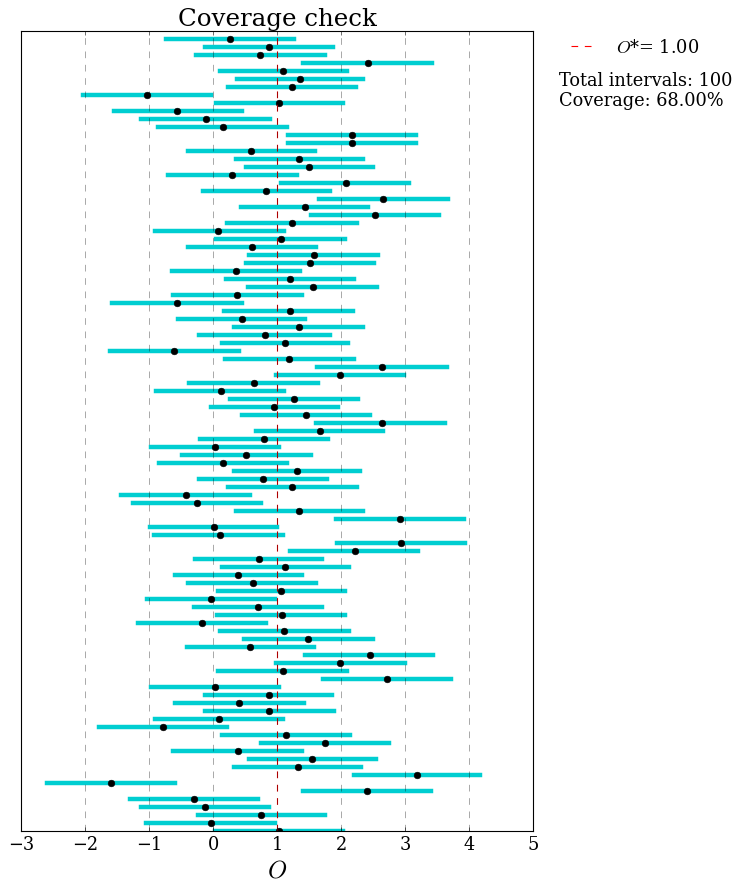

In [109]:
plot_confidence_intervals(O_true, means, lowers, uppers, coverage=0.68,
                          xlabel=r'$O$',
                          labels=None, title="Coverage check", color='darkturquoise')

In [161]:
area = 1
for i in range(2):
    bins = centroids_to_edges(bins_centroids[:,i])
    N = 20000
    bins_legth = (bins[1:]-bins[:-1])*N
    area *= np.sum(bins_legth*f_bins_centroids[:, i])
print(area)

(60, 2)

# Load test statistics from NPLM

In [183]:
import glob, h5py, math, time, os, json
from scipy.stats import norm, expon, chi2, uniform, chisquare
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

In [184]:
def Z_score_chi2(t,df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z

def Z_score_norm(t,mu, std):
    sf = norm.sf(t, mu, std)
    Z  = -norm.ppf(sf)
    return Z

def plot_1distribution(t, df, xmin=0, xmax=300, nbins=10, save=False, ymax=None, output_path='', save_name='', label=''):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!). 
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    Z_obs     = norm.ppf(chi2.cdf(np.median(t), df))
    t_obs_err = 1.2533*np.std(t)*1./np.sqrt(t.shape[0])
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t)+t_obs_err, df))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t)-t_obs_err, df))
    label  = 'sample %s\nsize: %i \nmedian: %s, std: %s\n'%(label, t.shape[0], str(np.around(np.median(t), 2)),str(np.around(np.std(t), 2)))
    label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    binswidth = (xmax-xmin)*1./nbins
    h = plt.hist(t, weights=np.ones_like(t)*1./(t.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=14) 
    plt.legend(prop=font, frameon=False)
    plt.xlabel('t', fontsize=18, fontname="serif")
    plt.ylabel('Probability', fontsize=18, fontname="serif")
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if ymax !=None:
        plt.ylim(0., ymax)
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_distribution.pdf')
            print('saved at %s'%(output_path+ save_name+'_distribution.pdf'))
    plt.show()
    plt.close(fig)
    return

def plot_2distribution(t1, t2, df, xmin=0, xmax=300, ymax=None, nbins=10, save=False, output_path='', label1='1', label2='2', save_name='', print_Zscore=True):
    '''
    Plot the histogram of a test statistics sample (t) and the target chi2 distribution (df must be specified!).
    The median and the error on the median are calculated in order to calculate the median Z-score and its error.
    '''
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig  = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    # plot distribution histogram
    bins      = np.linspace(xmin, xmax, nbins+1)
    binswidth = (xmax-xmin)*1./nbins
    # t1
    Z_obs     = Z_score_chi2(np.median(t1), df)
    t_obs_err = 1.2533*np.std(t1)*1./np.sqrt(t1.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t1)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t1)-t_obs_err, df)
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label1, t1.shape[0], str(np.around(np.median(t1), 2)),str(np.around(np.std(t1), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
    
    h = plt.hist(t1, weights=np.ones_like(t1)*1./(t1.shape[0]*binswidth), color='lightblue', ec='#2c7fb8',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t1.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h[0])
    # t2
    Z_obs     = Z_score_chi2(np.median(t2), df)
    t_obs_err = 1.2533*np.std(t2)*1./np.sqrt(t2.shape[0])
    Z_obs_p   = Z_score_chi2(np.median(t2)+t_obs_err, df)
    Z_obs_m   = Z_score_chi2(np.median(t2)-t_obs_err, df)
    t_empirical = np.sum(1.*(t1>np.mean(t2)))*1./t1.shape[0]
    empirical_lim = '='
    if t_empirical==0:
        empirical_lim='>'
        t_empirical = 1./t1.shape[0]
    t_empirical_err = t_empirical*np.sqrt(1./np.sum(1.*(t1>np.mean(t2))+1./t1.shape[0]))
    Z_empirical = norm.ppf(1-t_empirical)
    Z_empirical_m = norm.ppf(1-(t_empirical+t_empirical_err))
    Z_empirical_p = norm.ppf(1-(t_empirical-t_empirical_err))
                                          
    label  = '%s \nsize: %i\nmedian: %s, std: %s\n'%(label2, t2.shape[0], str(np.around(np.median(t2), 2)),str(np.around(np.std(t2), 2)))
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s) \n'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))
        label += 'empirical Z %s %s (+%s/-%s)'%(empirical_lim, str(np.around(Z_empirical, 2)), str(np.around(Z_empirical_p-Z_empirical, 2)), str(np.around(Z_empirical-Z_empirical_m, 2)))
    h = plt.hist(t2, weights=np.ones_like(t2)*1./(t2.shape[0]*binswidth), color='#8dd3c7', ec='seagreen',
                 bins=bins, label=label)
    err = np.sqrt(h[0]/(t2.shape[0]*binswidth))
    x   = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(x, h[0], yerr = err, color='seagreen', marker='o', ls='')
    max2 = np.max(h[0])
    # plot reference chi2
    x  = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(x, chi2.pdf(x, df),'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$'%(df))
    font = font_manager.FontProperties(family='serif', size=20) #weight='bold', style='normal', 
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2*np.maximum(max1, max2))#np.max(chi2.pdf(x, df))*1.3)
    if ymax !=None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            plt.savefig(output_path+ save_name+'_2distribution.pdf')
    plt.show()
    plt.close()
    return [Z_obs, Z_obs_p, Z_obs_m], [Z_empirical, Z_empirical_p, Z_empirical_m]

def Plot_Percentiles_ref(tvalues_check, dof, patience=1, title='', wc=None, ymax=300, ymin=0, save=False, output_path=''):
    '''
    The funcion creates the plot of the evolution in the epochs of the [2.5%, 25%, 50%, 75%, 97.5%] quantiles of the toy sample distribution.
    The percentile lines for the target chi2 distribution (dof required!) are shown as a reference.
    patience: interval between two check points (epochs).
    tvalues_check: array of t=-2*loss, shape = (N_toys, N_check_points)
    '''
    colors = [
    'seagreen',
    'mediumseagreen',
    'lightseagreen',
    '#2c7fb8',
    'midnightblue',
    ]
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    epochs_check = []
    nr_check_points = tvalues_check.shape[1]
    for i in range(nr_check_points):
        epoch_check = patience*(i+1)
        epochs_check.append(epoch_check)
    
    fig=plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')
    quantiles=[2.5, 25, 50, 75, 97.5]
    percentiles=np.array([])
    plt.xlabel('Training Epochs', fontsize=16, fontname="serif")
    plt.ylabel('t', fontsize=16, fontname="serif")
    plt.ylim(ymin, ymax)
    if wc != None:
        plt.title('Weight Clipping = '+wc, fontsize=16,  fontname="serif")
    for i in range(tvalues_check.shape[1]):
        percentiles_i = np.percentile(tvalues_check[:, i], quantiles)
        percentiles_i = np.expand_dims(percentiles_i, axis=1)
        if not i:
            percentiles = percentiles_i.T
        else:
            percentiles = np.concatenate((percentiles, percentiles_i.T))
    legend=[]
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, percentiles[:, j], marker='.', linewidth=3, color=colors[j])
        legend.append(str(quantiles[j])+' % quantile')
    for j in range(percentiles.shape[1]):
        plt.plot(epochs_check, chi2.ppf(quantiles[j]/100., df=dof, loc=0, scale=1)*np.ones_like(epochs_check),
                color=colors[j], ls='--', linewidth=1)
        #print( chi2.ppf(quantiles[j]/100., df=dof, loc=0, scale=1))
        if j==0:
            legend.append("Target "+r"$\chi^2(dof=$"+str(dof)+")")
    font = font_manager.FontProperties(family='serif', size=16)         
    plt.legend(legend, prop=font)
    plt.yticks(fontsize=16, fontname="serif")
    plt.xticks(fontsize=16, fontname="serif")
    if save:
        if output_path=='':
            print('argument output_path is not defined. The figure will not be saved.')
        else:
            fig.savefig(output_path+title+'_PlotPercentiles.pdf')
    plt.show()
    plt.close(fig)
    return

In [191]:
folders = {
    'ensemble_ref': './ensemble/calibration_tvalues_flksigma1.0.h5',
    'ensemble_generated': './ensemble/comparison_tvalues_flksigma1.0.h5',

    'f1_ref': './f1/calibration_tvalues_flksigma1.0.h5',
    'f1_generated': './f1/comparison_tvalues_flksigma1.0.h5',
}

In [192]:
tests = {}
for k in  list(folders.keys()):
    f = h5py.File(folders[k], 'r')
    flk_sigma = folders[k].split('flksigma')[-1].replace('.h5', '')
    tests[k] = np.array(f[flk_sigma])
    f.close()

argument output_path is not defined. The figure will not be saved.


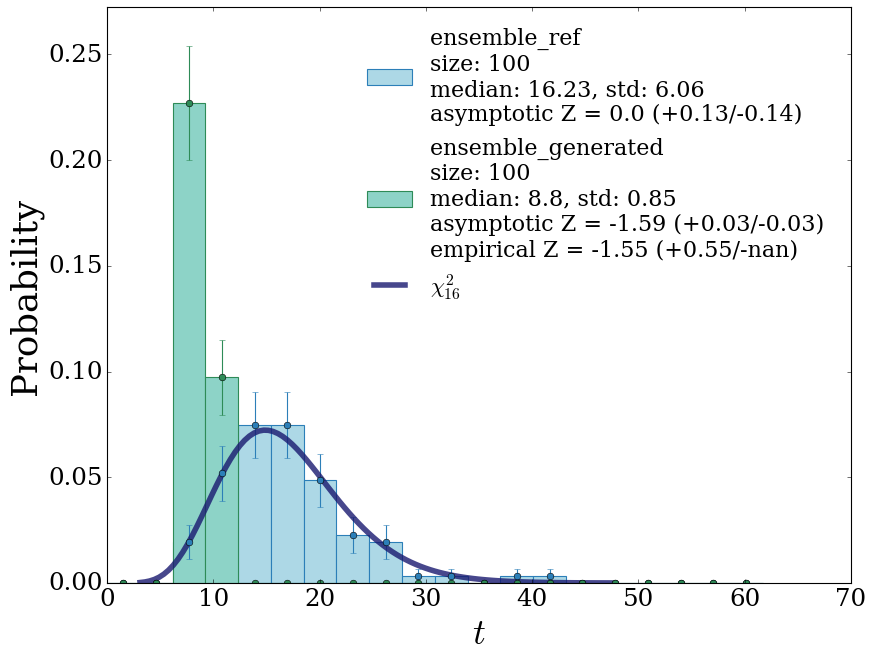

argument output_path is not defined. The figure will not be saved.


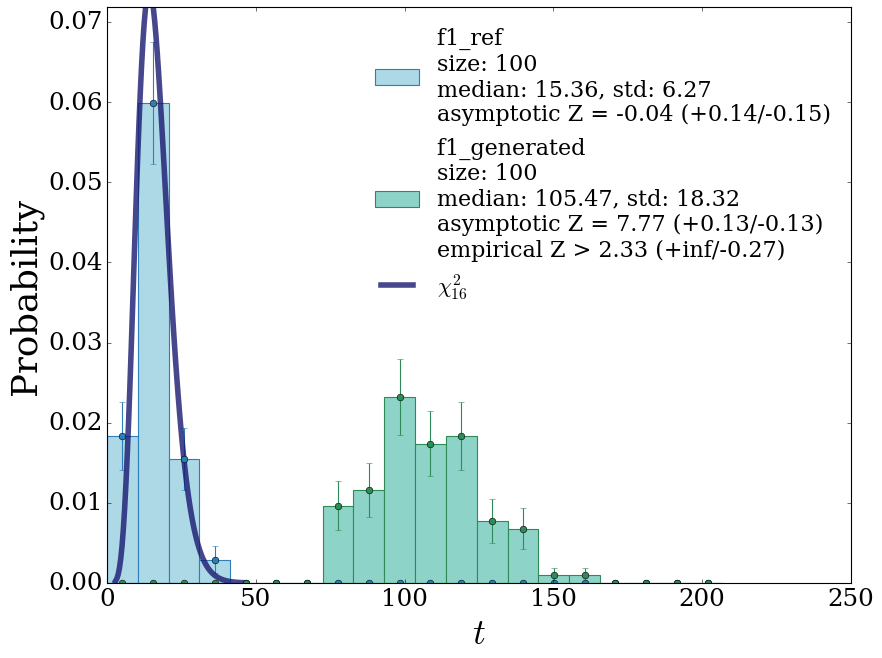

In [195]:
for key in list(tests.keys()):
    if 'ref' in key: continue
    #CHANGE
    key_ref = key.replace('generated', 'ref')
    t1 = tests[key_ref]
    t2 = tests[key]
    df = np.mean(t1)
    xmax = np.max(t2)+50
    xmin = 0#np.min(t1)
    plot_2distribution(t1, t2, df, xmin=xmin, xmax=xmax, ymax=None, nbins=20, 
                   save=True, output_path='', label1=key_ref, label2=key, save_name='', print_Zscore=True)